## Import Dependencies

In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import os 
import matplotlib.pyplot as plt 
import tensorflow_io as tfio 

In [2]:
# prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Build Data Loading Function

In [3]:
CAT_FILE = "Cats_and_dogs/cats_dogs/cat_1.wav"
DOG_FILE = "Cats_and_dogs/cats_dogs/dog_barking_1.wav"

In [4]:
# load audio files and produce waveform
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate=tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav 

In [5]:
# Test on files
cat_wave = load_wav(CAT_FILE)
dog_wave = load_wav(DOG_FILE)

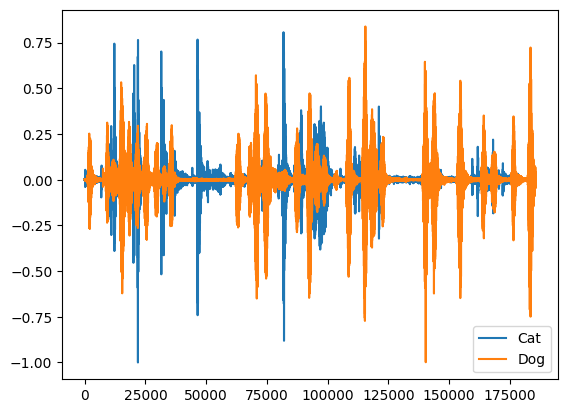

In [6]:
plt.plot(cat_wave, label="Cat")
plt.plot(dog_wave, label="Dog")
plt.legend()

## Create Tensorflow Dataset

In [7]:
CAT_TRAIN = os.path.join('Cats_and_dogs', 'cats_dogs', 'train', 'cat')
DOG_TRAIN = os.path.join('Cats_and_dogs', 'cats_dogs', 'train', 'dog')

In [8]:
cat_train = tf.data.Dataset.list_files(CAT_TRAIN+'\*.wav')
dog_train = tf.data.Dataset.list_files(DOG_TRAIN+'\*.wav')

In [9]:
cat_train.as_numpy_iterator().next()

b'Cats_and_dogs\\cats_dogs\\train\\cat\\cat_146.wav'

In [10]:
cats = tf.data.Dataset.zip((cat_train, tf.data.Dataset.from_tensor_slices(tf.ones(len(cat_train)))))
dogs = tf.data.Dataset.zip((dog_train, tf.data.Dataset.from_tensor_slices(tf.zeros(len(dog_train)))))
data = cats.concatenate(dogs)

In [11]:
data.shuffle(10000).as_numpy_iterator().next()

(b'Cats_and_dogs\\cats_dogs\\train\\cat\\cat_89.wav', 1.0)

## Get Average Length of Cat Audio

In [12]:
lengths = []

for file in os.listdir(CAT_TRAIN):
    tensor_wav = load_wav(os.path.join('Cats_and_dogs', 'cats_dogs', 'train', 'cat', file))
    lengths.append(len(tensor_wav))


In [13]:
print("Mean: ", tf.math.reduce_mean(lengths))
print("Min: ", tf.math.reduce_min(lengths))
print("Max: ", tf.math.reduce_max(lengths))

Mean:  tf.Tensor(133182, shape=(), dtype=int32)
Min:  tf.Tensor(15067, shape=(), dtype=int32)
Max:  tf.Tensor(283008, shape=(), dtype=int32)


In [14]:
print("> 200000:", len([x for x in lengths if x > 200000]))
print("> 175000:", len([x for x in lengths if x > 175000]))

> 200000: 6
> 175000: 61


(array([29.,  7.,  6.,  5.,  6., 11., 55.,  2.,  2.,  2.]),
 array([ 15067. ,  41861.1,  68655.2,  95449.3, 122243.4, 149037.5,
        175831.6, 202625.7, 229419.8, 256213.9, 283008. ]),
 <BarContainer object of 10 artists>)

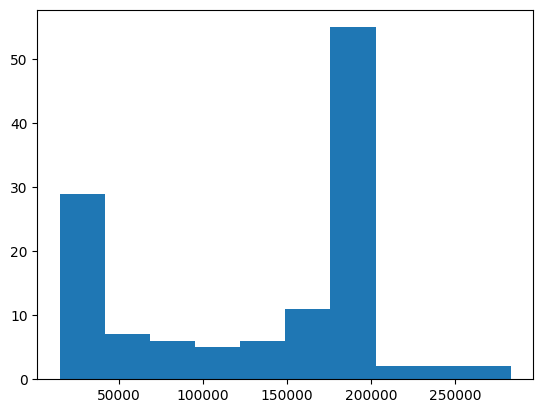

In [15]:
plt.hist(lengths)

In [16]:
# get files of at most 150000 timesteps and pad the shorter ones
def preprocess(file_path, label):
    wav = load_wav(file_path)
    wav = wav[:150000]
    zero_padding = tf.zeros([150000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav], 0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [17]:
# Test
filepath, label = cats.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [18]:
# Test
spectrogram, label = preprocess(filepath, label)

In [19]:
spectrogram

<tf.Tensor: shape=(4678, 257, 1), dtype=float32, numpy=
array([[[1.3854620e+00],
        [1.2051684e+00],
        [9.0345508e-01],
        ...,
        [2.1291507e-04],
        [8.3472965e-05],
        [8.7678432e-05]],

       [[1.2583324e+00],
        [9.8117232e-01],
        [6.2195754e-01],
        ...,
        [2.9649783e-04],
        [1.4095812e-04],
        [1.4650822e-04]],

       [[1.1639411e+00],
        [7.4639195e-01],
        [1.7529069e-01],
        ...,
        [3.7418088e-04],
        [2.1355490e-04],
        [1.6474724e-04]],

       ...,

       [[9.7317892e-01],
        [1.3070015e+00],
        [1.3578204e+00],
        ...,
        [1.2878673e-03],
        [4.5201374e-04],
        [2.5898218e-04]],

       [[1.5309495e-01],
        [8.7786072e-01],
        [1.1416649e+00],
        ...,
        [1.2449551e-03],
        [6.7625131e-04],
        [3.0390173e-04]],

       [[4.4642568e-01],
        [7.4647784e-01],
        [8.7105483e-01],
        ...,
        [1.1359764

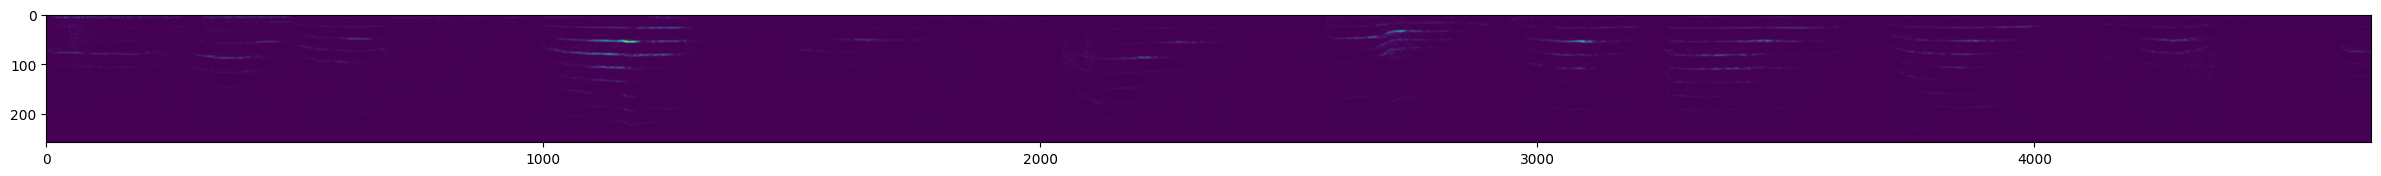

In [20]:
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## Create Training and Validating Partitions

In [21]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [22]:
len(data)

14

In [23]:
train = data.take(10)
val = data.skip(10).take(4)

In [24]:
samples, labels = train.as_numpy_iterator().next()

In [25]:
samples.shape

(16, 4678, 257, 1)

In [26]:
labels

array([0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0.],
      dtype=float32)

## Build Model

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [28]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(4678, 257, 1)))
model.add(MaxPooling2D((2,2)))
model.add(MaxPooling2D((2,2)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(MaxPooling2D((2,2)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [29]:
model.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 4676, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2338, 127, 16)    0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1169, 63, 16)     0         
 2D)                                                             
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 584, 31, 16)      0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 582, 29, 16)       2320      
                                                        

In [31]:
hist = model.fit(train, epochs=6, validation_data=val)

Epoch 1/6
10/10 [==============================] - 8s 227ms/step - loss: 0.9163 - recall: 0.6931 - precision: 0.7000 - val_loss: 0.3567 - val_recall: 0.9167 - val_precision: 0.8684
Epoch 2/6
10/10 [==============================] - 2s 192ms/step - loss: 0.3771 - recall: 0.8191 - precision: 0.8953 - val_loss: 0.3553 - val_recall: 0.9310 - val_precision: 0.9000
Epoch 3/6
10/10 [==============================] - 2s 191ms/step - loss: 0.2635 - recall: 0.9570 - precision: 0.9468 - val_loss: 0.1729 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/6
10/10 [==============================] - 2s 191ms/step - loss: 0.2252 - recall: 0.9570 - precision: 0.9271 - val_loss: 0.0941 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/6
10/10 [==============================] - 2s 190ms/step - loss: 0.1329 - recall: 0.9787 - precision: 0.9684 - val_loss: 0.1219 - val_recall: 1.0000 - val_precision: 0.9286
Epoch 6/6
10/10 [==============================] - 2s 188ms/step - loss: 0.0878 - recall: 0.989

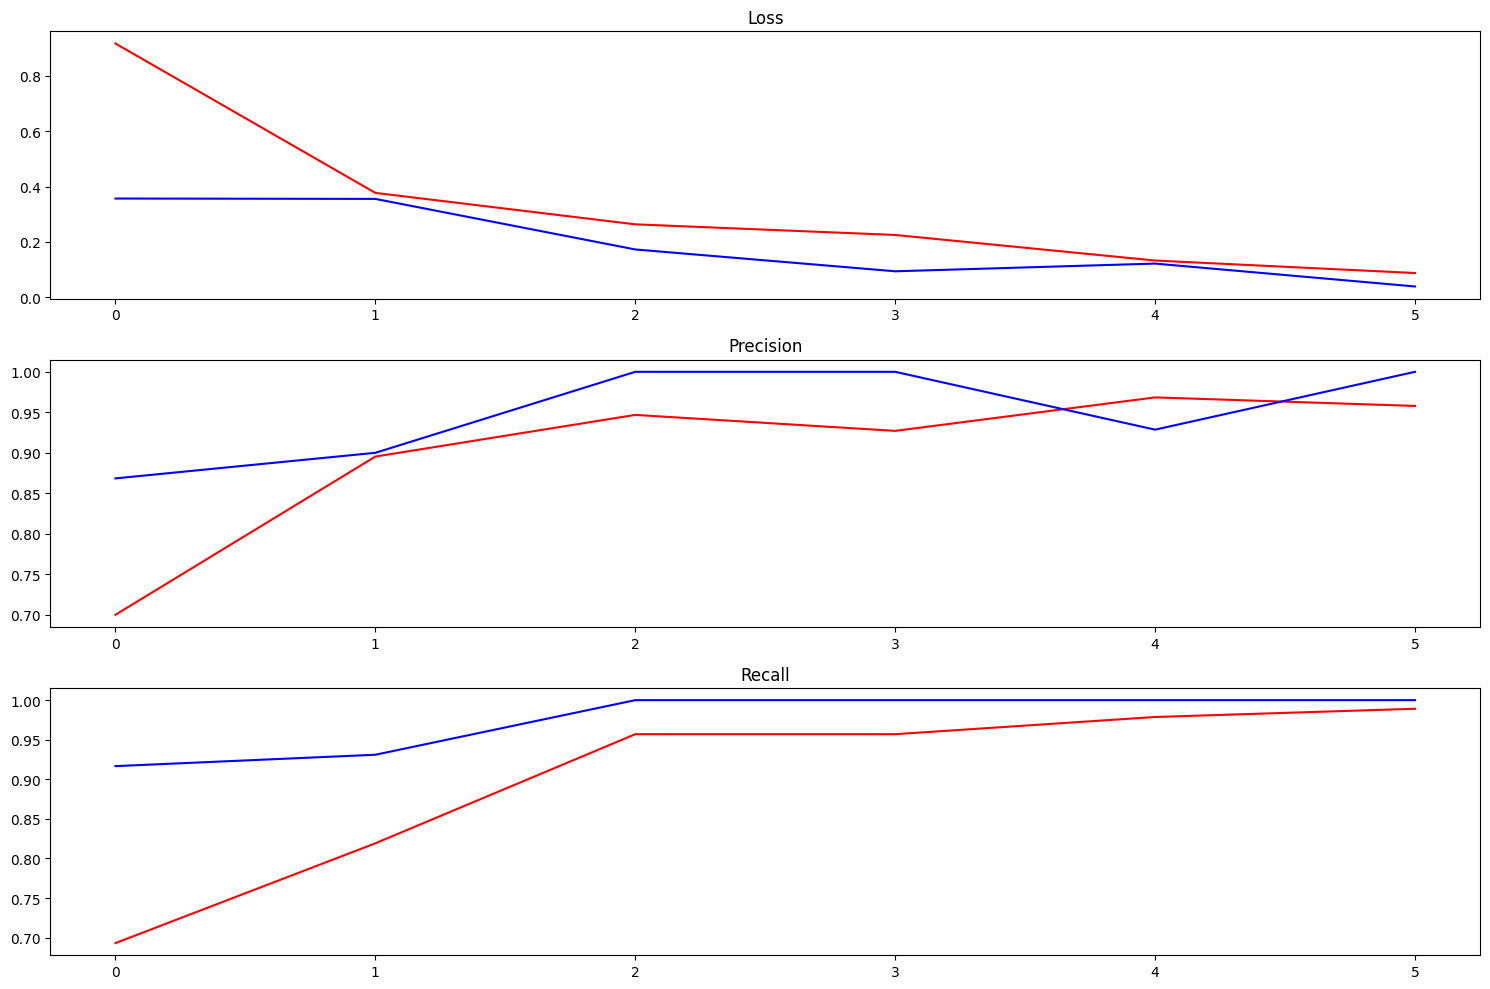

In [32]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'], 'r')
axs[0].plot(hist.history['val_loss'], 'b')

axs[1].set_title("Precision")
axs[1].plot(hist.history['precision'], 'r')
axs[1].plot(hist.history['val_precision'], 'b')

axs[2].set_title("Recall")
axs[2].plot(hist.history['recall'], 'r')
axs[2].plot(hist.history['val_recall'], 'b')

plt.tight_layout()

## Make a Prediction on a Single Clip

In [33]:
X_test, y_test = val.as_numpy_iterator().next() 

In [34]:
y_test.shape

(16,)

In [35]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 269ms/step


In [36]:
yhat 

array([[1.1272250e-03],
       [1.8047050e-03],
       [9.9999988e-01],
       [9.5058137e-01],
       [9.0329754e-01],
       [7.8470454e-02],
       [5.2363817e-03],
       [9.9725866e-01],
       [1.0000000e+00],
       [7.3269504e-04],
       [1.0000000e+00],
       [2.0786069e-02],
       [9.9760050e-01],
       [9.7357279e-01],
       [9.7966927e-01],
       [9.9992311e-01]], dtype=float32)

In [37]:
yhat = [1 if x > 0.5 else 0 for x in yhat]

In [38]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=10>

In [39]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [40]:
model.save('cat_dog.keras')